In [2]:
pip install gym numpy matplotlib

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 399.6 kB/s eta 0:00:19
   -- ------------------------------------- 0.5/7.8 MB 399.6 kB/s eta 0:00:19
   ---- ----------------------------------- 0.8/7.8 MB 419.4 kB/s eta 0:00:17
   ---- ----------------------------------- 0.8/7.8 MB 419.4 kB/s eta 0:00:17
   ---- ----------------------------------- 0.8/7.8 MB 419.4 kB/s eta 0:00:17
   --------- ------------------------------ 1.8/7.8 MB 846.1 kB/s eta 0:00:08
   ----------------- ---------------------- 3.4/7.8 MB 1.5 MB/s eta 0:00:03
   ------------------------- -------------

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

c:\Users\samdd\anaconda3\envs\gymenv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


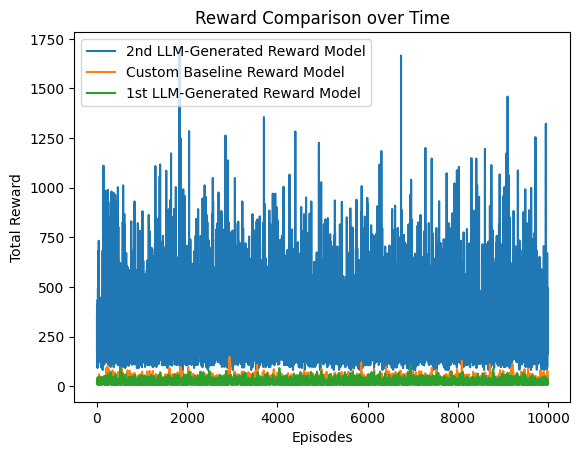

In [3]:
env = gym.make('CartPole-v1')

#Baseline State of the Art Reward Function
def SoTARewardFunction(observation, action):
    x, _, theta, _ = observation
    
    if abs(theta) > np.deg2rad(15) or abs(x) > 2.4:
        return 0
    
    return 1

#LLM-generated reward model
def LLMRewardFunction1(observation, action):
    x, _, angle, _ = observation
    reward = 1.0 - abs(angle) - 0.5 * abs(x)
    return max(0, reward)

def LLMRewardFunction2(observation, action):
    x, _, angle, _ = observation
    reward = 1.0
    
    if abs(x) > 2.4 or abs(angle) > 0.2:
        reward = -10.0
    else:
        reward += 10.0 / (1.0 + abs(angle))
        reward += 5.0 / (1.0 + abs(x))
    
    return int(reward)

#train agent
def train(env, rewardModel, episodes=500):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()
        totalReward = 0
        done = False
        while not done:
            action = env.action_space.sample()


            observation, reward, done, _, _ = env.step(action)

            adjustedReward = rewardModel(observation, reward)
            totalReward += adjustedReward
        rewards.append(totalReward)
    return rewards

# Run experiments
episodes = 10000
baselineRewards = train(env, SoTARewardFunction, episodes)
LLM1Rewards = train(env, LLMRewardFunction1, episodes)
LLM2Rewards = train(env, LLMRewardFunction2, episodes)

# Plot results
plt.plot(np.arange(episodes), LLM2Rewards, label="2nd LLM-Generated Reward Model")
plt.plot(np.arange(episodes), baselineRewards, label="Custom Baseline Reward Model")
plt.plot(np.arange(episodes), LLM1Rewards, label="1st LLM-Generated Reward Model")

plt.xlabel("Episodes")
plt.ylabel("Total Reward")

plt.title("Reward Comparison over Time")

plt.legend()
plt.show()


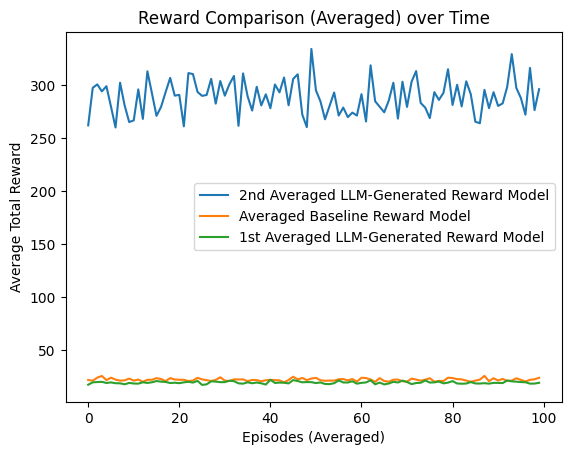

In [4]:


def averageRewards(rewards, groupSize=100):
    groupedRewards = np.mean(np.reshape(rewards[:len(rewards) - len(rewards) % groupSize], (-1, groupSize)), axis=1)
    return groupedRewards

# Apply averaging
avgBaseline = averageRewards(baselineRewards, groupSize=100)
avgLLM1 = averageRewards(LLM1Rewards, groupSize=100)
avgLLM2 = averageRewards(LLM2Rewards, groupSize=100)

# Plot results with averaging
plt.plot(np.arange(len(avgLLM2)), avgLLM2, label="2nd Averaged LLM-Generated Reward Model")
plt.plot(np.arange(len(avgBaseline)), avgBaseline, label="Averaged Baseline Reward Model")
plt.plot(np.arange(len(avgLLM1)), avgLLM1, label="1st Averaged LLM-Generated Reward Model")

plt.xlabel("Episodes (Averaged)")
plt.ylabel("Average Total Reward")
plt.title("Reward Comparison (Averaged) over Time")
plt.legend()
plt.show()


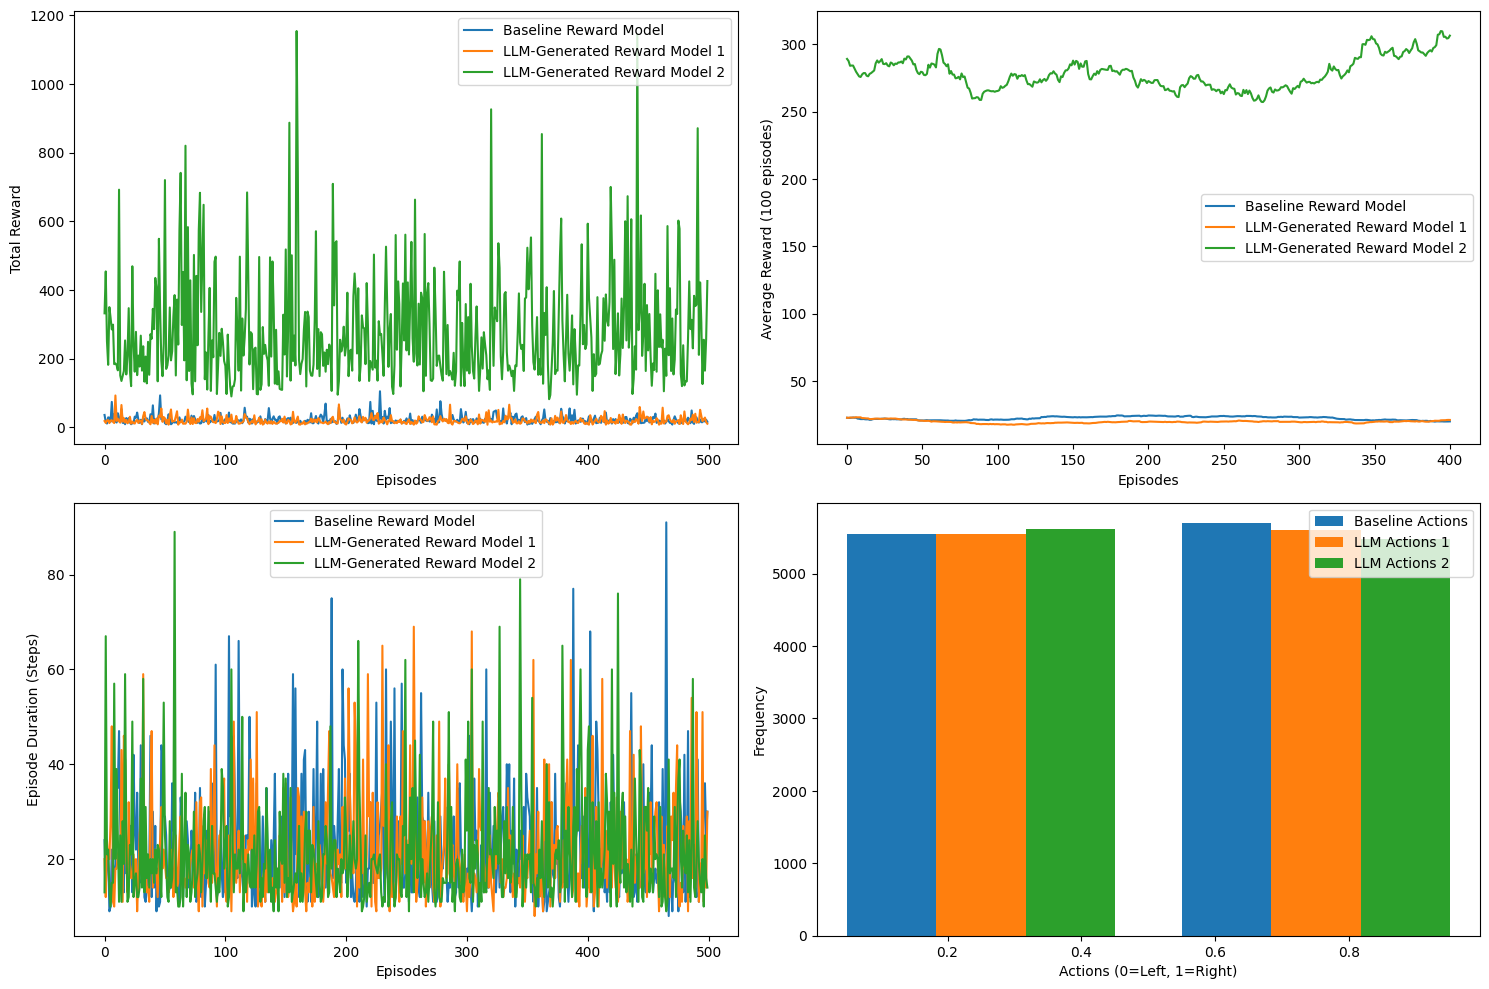

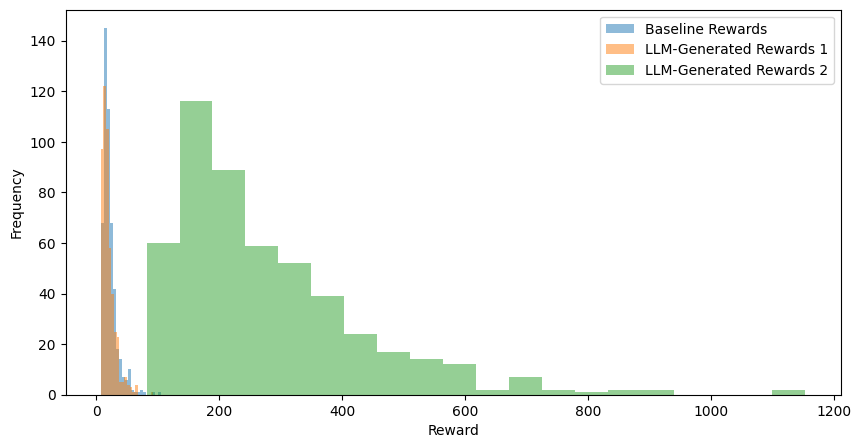

Baseline Success Rate: 0.00%
LLM-Generated Success Rate 1: 0.00%
LLM-Generated Success Rate 2: 62.00%


In [5]:
env = gym.make('CartPole-v1')


def movingAverage(data, windowSize=100):
    return np.convolve(data, np.ones(windowSize) / windowSize, mode='valid')





episodes = 500 
baselineRewards = train(env, SoTARewardFunction, episodes)
llmRewards1 = train(env, LLMRewardFunction1, episodes)
llmRewards2 = train(env, LLMRewardFunction2, episodes)


plt.figure(figsize=(15, 10))


#Total Reward Comparison
plt.subplot(2, 2, 1)
plt.plot(np.arange(episodes), baselineRewards, label="Baseline Reward Model")
plt.plot(np.arange(episodes), llmRewards1, label="LLM-Generated Reward Model 1")
plt.plot(np.arange(episodes), llmRewards2, label="LLM-Generated Reward Model 2")


plt.xlabel("Episodes")
plt.ylabel("Total Reward")

plt.legend()

# 2.Running Average of Rewards
plt.subplot(2, 2, 2)
plt.plot(np.arange(len(movingAverage(baselineRewards))), movingAverage(baselineRewards), label="Baseline Reward Model")
plt.plot(np.arange(len(movingAverage(llmRewards1))), movingAverage(llmRewards1), label="LLM-Generated Reward Model 1")
plt.plot(np.arange(len(movingAverage(llmRewards2))), movingAverage(llmRewards2), label="LLM-Generated Reward Model 2")


plt.xlabel("Episodes")
plt.ylabel("Average  Reward")
plt.legend()

# 3. Episode Duration
def episodeDuration(env, rewardModel, episodes=500):
    durations = []
    for episode in range(episodes):
        observation = env.reset()
        done = False
        duration = 0

        while not done:
            action = env.action_space.sample()
            observation, reward, done, _, _ = env.step(action)
            duration += 1  
        durations.append(duration)

    return durations

# Get the episode durations
baselineDurations = episodeDuration(env, SoTARewardFunction, episodes)
llmDurations1 = episodeDuration(env, LLMRewardFunction1, episodes)
llmDurations2 = episodeDuration(env, LLMRewardFunction2, episodes)

# Plot Episode Duration
plt.subplot(2, 2, 3)
plt.plot(np.arange(episodes), baselineDurations, label="Baseline Reward Model")
plt.plot(np.arange(episodes), llmDurations1, label="LLM-Generated Reward Model 1")
plt.plot(np.arange(episodes), llmDurations2, label="LLM-Generated Reward Model 2")


plt.xlabel("Episodes")
plt.ylabel("Episode Duration(Steps)")
plt.legend()

# 4.action distribution
def getActionDistribution(env, rewardModel, episodes):
    actions = []
    for episode in range(episodes):
        observation = env.reset()
        done = False

        while not done:
            action = env.action_space.sample() 
            actions.append(action)
            observation, _, done, _, _ = env.step(action)

    return actions

baselineActions = getActionDistribution(env, SoTARewardFunction, episodes)
llmActions1 = getActionDistribution(env, LLMRewardFunction1, episodes)
llmActions2 = getActionDistribution(env, LLMRewardFunction2, episodes)

plt.subplot(2, 2, 4)
plt.hist([baselineActions, llmActions1, llmActions2], label=["Baseline Actions", "LLM Actions 1", "LLM Actions 2"], bins=2)

plt.xlabel("Actions(0=Left, 1=Right)")
plt.ylabel("Frequency")

plt.legend()
plt.tight_layout()
plt.show()

# 5. Reward Distribution
plt.figure(figsize=(10, 5))
plt.hist(baselineRewards, bins=20, alpha=0.5, label='Baseline Rewards')
plt.hist(llmRewards1, bins=20, alpha=0.5, label='LLM-Generated Rewards 1')
plt.hist(llmRewards2, bins=20, alpha=0.5, label='LLM-Generated Rewards 2')

plt.xlabel("Reward")
plt.ylabel("Frequency")


plt.legend()
plt.show()

# 6. Success Rate Calc
successThreshold = 200

baselineSuccessRate = sum([1 if r >= successThreshold else 0 for r in baselineRewards]) / episodes
llmSuccessRate1 = sum([1 if r >= successThreshold else 0 for r in llmRewards1]) / episodes
llmSuccessRate2 = sum([1 if r >= successThreshold else 0 for r in llmRewards2]) / episodes

print(f"Baseline Success Rate: {baselineSuccessRate * 100:.2f}%")
print(f"LLM-Generated Success Rate 1: {llmSuccessRate1 * 100:.2f}%")
print(f"LLM-Generated Success Rate 2: {llmSuccessRate2 * 100:.2f}%")



In [10]:
env = gym.make('CartPole-v1', render_mode="human")

def visualizeSuccessfulRuns(env, rewards, rewardModelName, successThreshold):
    cnt = 0
    for i, reward in enumerate(rewards):
        if reward >= successThreshold: 
            print("Reward: " + str(reward), flush=True)
            observation, _ = env.reset()
            done = False
            print(f"Visualizing successful run {i+1} with {rewardModelName} model")
            
            while not done:
                action = env.action_space.sample()
                observation, reward, done, _, _ = env.step(action)
                
                #Render enviroment
                env.render()
                
                time.sleep(0.01) 

            print(f"End of successful run {i+1} with {rewardModelName} model")

        #20 Run lim
        cnt += 1
        if cnt == 20:
            break
    
    env.close()  


successThreshold = 300 
visualizeSuccessfulRuns(env, baselineRewards, "Baseline", successThreshold)
visualizeSuccessfulRuns(env, llmRewards1, "LLMRewardFunction1", successThreshold)
visualizeSuccessfulRuns(env, llmRewards2, "LLMRewardFunction2", successThreshold)


Reward: 332
Visualizing successful run 1 with LLMRewardFunction2 model
End of successful run 1 with LLMRewardFunction2 model
Reward: 454
Visualizing successful run 2 with LLMRewardFunction2 model
End of successful run 2 with LLMRewardFunction2 model
Reward: 350
Visualizing successful run 5 with LLMRewardFunction2 model
End of successful run 5 with LLMRewardFunction2 model
Reward: 319
Visualizing successful run 6 with LLMRewardFunction2 model
End of successful run 6 with LLMRewardFunction2 model
Reward: 692
Visualizing successful run 13 with LLMRewardFunction2 model
End of successful run 13 with LLMRewardFunction2 model


In [ ]:
#Maybe run many instances of reward models generated by Claude. Compare, with SoTA as baseline